#Intro
In this notebook, I am investigating the use of transformers for the estimation of complex systems. In particular, I am interested in Cellular Automata, systems where each point ("cell") in a grid at timestep $t$ is assigned a value based only on the surrounding cells at timestep $t-1$. As this is a markov process, it is possible to model it as a sequence to sequence transformation, and as such only requires a transformer encoder architecture. Of course, using a transformer (which excels at studying long-range dependencies within sequences) for the study of entirely local cellular automata is overkill, and a CNN would be far better suited for that task. However, what I am interested in is how accurately a transformer can estimate the state of a cellular automaton $n$ timesteps into the future, without explicitly calculating all intermediary steps. As future states of a CA depend on longer-range interactions, a transformer is well-suited for this job.

In [1]:
# Standard libraries
import os
import numpy as np
import math
import json
from functools import partial

## Imports for plotting
import matplotlib.pyplot as plt
plt.set_cmap('cividis')
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgb
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.reset_orig()
from tqdm.auto import tqdm
# import jax.tools.colab_tpu
# jax.tools.colab_tpu.setup_tpu()

## JAX
import jax
import jax.numpy as jnp
from jax import random
main_rng = random.PRNGKey(42)
import flax
from flax import linen as nn
from flax.training import train_state, checkpoints
import optax

## PyTorch
import torch
import torch.utils.data as data
from torch.utils.tensorboard import SummaryWriter
import torchvision
from torchvision import transforms
from torchvision.datasets import CIFAR100

from google.colab import drive
drive.mount('/content/drive')
CHECKPOINT_PATH = '/content/drive/MyDrive/Transformer_for_CA'
DATASET_PATH = '/content/drive/MyDrive/Transformer_for_CA/CA_data'



<ipython-input-1-91c2409c8def>:13: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf') # For export


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<Figure size 640x480 with 0 Axes>

#Cellular Automata
For this experiment, I will be using a simple type of cellular automata called an Elementary Cellular Automaton. These automata are easily expressed through an 8 bit encoding of a rule and a simple function to determine the evolution of the state based on the previous state. As the state is 1 dimensional, these ECAs are typically shown as 2 dimensional grids where 1 dimension is the time steps. Two examples of ECAs, Rule30 and Rule90, are shown below.

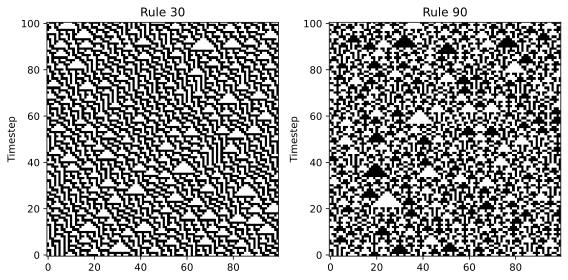

In [685]:
rule30 = np.array([0, 1, 1, 1, 1, 0, 0, 0], dtype=float)
rule90 = np.array([0,1,0,1,1,0,1,0], dtype=float)
rule105 = np.array([0, 1, 1, 0, 1, 0, 0, 1], dtype=float)

def apply_rule(state, rule):
    new = np.zeros(len(state))
    for i in range(0,len(state)):
        new[i] = (rule[int(state[i-1]*4) + int(state[i]*2) + int(state[(i+1)%len(state)])]) #binary indexing into the rule
    return new

def evolve(rule, initial_state, steps):
    state = initial_state.copy()
    history = [state.copy()]

    for _ in range(steps):
        state = apply_rule(state, rule)
        history.append(state.copy())

    return history


initial_state = np.random.randint(0,2, 100,dtype=int)
initial_state[50] = 1
steps = 100
evolution_history_rule30 = evolve(rule30, initial_state, steps)
evolution_history_rule90 = evolve(rule105, initial_state, steps)
fig_combined, axes = plt.subplots(1, 2, figsize=(8, 4))

axes[0].imshow(evolution_history_rule30, cmap="binary", interpolation="nearest", origin="lower") # Get the image data
axes[0].set_title("Rule 30")
axes[0].set_ylabel("Timestep")

axes[1].imshow(evolution_history_rule90, cmap="binary", interpolation="nearest", origin="lower") # Get the image data
axes[1].set_title("Rule 90")
axes[1].set_ylabel("Timestep")

plt.tight_layout()
plt.show()

##Transformer architecture
For the transformer, I am using the Jax and Flax libraries to implement a simple multi-head attention layer transformer. I do not implement positional embedding, as a more suitable inductive bias given the locality of CA effects is ALIBI (Detailed in "Train Short, Test Long: Attention with Linear Biases Enables Input Length Extrapolation"). We use a modified version of ALIBI where it uses a modulus to wrap around, i.e tokens at the beginning are treated as close to tokens at the end. This is because this is how Cellular Automata usually work.

In [551]:
def get_alibi_slopes(num_heads: int):
    def get_slopes_power_of_2(n):
        start = 2**(-2**-(jnp.log2(n)-3))
        ratio = start
        return jnp.array([start*ratio**i for i in range(n)])

    if num_heads == 1:  # Handle the case where num_heads is 1 directly
        return get_slopes_power_of_2(1)
    elif num_heads % 2 == 0:
        slopes = get_slopes_power_of_2(num_heads)
    else:
        slopes = get_slopes_power_of_2(num_heads - 1)
        slopes = jnp.concatenate([slopes, slopes[-1:]])
    return slopes

def compute_wrap_around_distance(a, b):
    # Compute absolute difference
    seq_length = a.shape[0]
    abs_diff = jnp.abs(a - b)
    # Compute wrap-around distance
    wrap_diff = jnp.minimum(abs_diff, abs(seq_length - abs_diff))
    return wrap_diff

In [552]:
def scaled_dot_product(k, q, v, mask=None, alibi_slopes=None):
    d_k = q.shape[-1]
    attn_logits = jnp.matmul(q, jnp.swapaxes(k, -1, -2)) / jnp.sqrt(d_k)

    # Apply ALiBi before masking
    if alibi_slopes is not None:
        batch_size, num_heads, q_seq_length, _ = q.shape
        _, _, k_seq_length, _ = k.shape

        # Compute absolute distance matrix |i - j|
        i = jnp.arange(q_seq_length)[:, None]  # shape (q_seq_length, 1)
        j = jnp.arange(k_seq_length)[None, :]  # shape (1, k_seq_length)
        distance = compute_wrap_around_distance(i,j)  # shape (q_seq_length, k_seq_length)
        #print(distance)

        # Reshape slopes to (1, num_heads, 1, 1) for broadcasting
        alibi_slopes = alibi_slopes.reshape(1, num_heads, 1, 1)
        alibi_matrix = alibi_slopes * distance  # shape (1, num_heads, q_seq_length, k_seq_length)
        #print(alibi_matrix)
        attn_logits = attn_logits + alibi_matrix
        #print(attn_logits)

    # Apply mask after ALiBi
    if mask is not None:
        attn_logits = jnp.where(mask, -9e18, attn_logits)

    attention = nn.softmax(attn_logits, axis=-1)
    values = jnp.matmul(attention, v)
    return values, attention

In [553]:
batch_size = 1
num_heads = 1
q_seq_length = 4
k_seq_length = 4
d_k = 2

# Dummy k, q, v (random values for demonstration)
key_dummy = jax.random.normal(jax.random.key(0), (batch_size, num_heads, k_seq_length, d_k))
query_dummy = jax.random.normal(jax.random.key(1), (batch_size, num_heads, q_seq_length, d_k))
value_dummy = jax.random.normal(jax.random.key(2), (batch_size, num_heads, k_seq_length, d_k))

# Calculate ALiBi slopes
alibi_slopes_dummy = get_alibi_slopes(num_heads)

# --- Run the function and print ALiBi matrix ---
values_output, attention_output = scaled_dot_product(
    k=key_dummy,
    q=query_dummy,
    v=value_dummy,
    alibi_slopes=alibi_slopes_dummy
)

print("\nAttention Output Shape:", attention_output.shape)
print("Values Output Shape:", values_output.shape)


Attention Output Shape: (1, 1, 4, 4)
Values Output Shape: (1, 1, 4, 2)


In [554]:
def expand_mask(mask):
    assert mask.ndim >= 2, "Mask must be at least 2-dimensional with seq_length x seq_length"
    if mask.ndim == 3:
        mask = mask.unsqueeze(1)
    while mask.ndim < 4:
        mask = mask.unsqueeze(0)
    return mask

In [555]:
class MultiHeadAttention(nn.Module):
    embed_dim : int
    num_heads : int

    def setup(self):
        self.qkv_proj = nn.Dense(3 * self.embed_dim)
        self.o_proj = nn.Dense(self.embed_dim)
        self.alibi_slopes = get_alibi_slopes(self.num_heads)  # Pre-calculate slopes

    def __call__(self, x, mask=None):
        batch_size, seq_length, embed_dim = x.shape
        if mask is not None:
            mask = expand_mask(mask)
        qkv = self.qkv_proj(x)

        qkv = qkv.reshape(batch_size, seq_length, self.num_heads, -1)
        qkv = qkv.transpose(0,2,1,3)
        q, k, v = jnp.split(qkv, 3, axis=-1)


        values, attention = scaled_dot_product(k, q, v, mask=mask, alibi_slopes = self.alibi_slopes)
        values = values.transpose(0, 2, 1, 3) # [Batch, SeqLen, Head, Dims]
        values = values.reshape(batch_size, seq_length, embed_dim)
        o = self.o_proj(values)

        return o, attention

In [556]:
class EncoderBlock(nn.Module):
    input_dim : int  # Input dimension is needed here since it is equal to the output dimension (residual connection)
    num_heads : int
    dim_feedforward : int
    dropout_prob : float

    def setup(self):
        # Attention layer
        self.self_attn = MultiHeadAttention(embed_dim=self.input_dim,
                                            num_heads=self.num_heads)
        # Two-layer MLP
        self.linear = [
            nn.Dense(self.dim_feedforward),
            nn.Dropout(self.dropout_prob),
            nn.relu,
            nn.Dense(self.input_dim)
        ]
        # Layers to apply in between the main layers
        self.norm1 = nn.LayerNorm()
        self.norm2 = nn.LayerNorm()
        self.dropout = nn.Dropout(self.dropout_prob)

    def __call__(self, x, mask=None, train=True):
        # Attention part
        attn_out, _ = self.self_attn(x, mask=mask)
        x = x + self.dropout(attn_out, deterministic=not train)
        x = self.norm1(x)

        # MLP part
        linear_out = x
        for l in self.linear:
            linear_out = l(linear_out) if not isinstance(l, nn.Dropout) else l(linear_out, deterministic=not train)
        x = x + self.dropout(linear_out, deterministic=not train)
        x = self.norm2(x)

        return x


In [557]:
class TransformerEncoder(nn.Module):
    num_layers : int
    input_dim : int
    num_heads : int
    dim_feedforward : int
    dropout_prob : float

    def setup(self):
        self.layers = [EncoderBlock(self.input_dim, self.num_heads, self.dim_feedforward, self.dropout_prob) for _ in range(self.num_layers)]

    def __call__(self, x, mask=None, train=True):
        for l in self.layers:
            x = l(x, mask=mask, train=train)
        return x

    def get_attention_maps(self, x, mask=None, train=True):
        attention_maps = []
        for l in self.layers:
            _, attn_map = l.self_attn(x, mask=mask)
            attention_maps.append(attn_map)
            x = l(x, mask=mask, train=train)
        return attention_maps

In [573]:
class TransformerPredictor(nn.Module):
    model_dim : int                   # Hidden dimensionality to use inside the Transformer
    num_heads : int                   # Number of heads to use in the Multi-Head Attention blocks
    num_layers : int                  # Number of encoder blocks to use
    dropout_prob : float = 0.0        # Dropout to apply inside the model
    input_dropout_prob : float = 0.0  # Dropout to apply on the input features

    def setup(self):
        # Input dim -> Model dim
        self.input_layer = nn.Dense(self.model_dim)
        # Transformer
        self.transformer = TransformerEncoder(num_layers=self.num_layers,
                                              input_dim=self.model_dim,
                                              dim_feedforward=2*self.model_dim,
                                              num_heads=self.num_heads,
                                              dropout_prob=self.dropout_prob)
        # Output classifier per sequence element
        self.output_net = [
            nn.Dense(self.model_dim),
            nn.LayerNorm(),
            nn.relu,
            nn.Dropout(self.dropout_prob),
            nn.Dense(1),
            #nn.sigmoid                             #Using sigmoid as the cell should be between 0 and 1 inclusive
        ]

    def __call__(self, x, mask=None, train=True):
        batch_size, seq_len = x.shape
        x = x.reshape(batch_size * seq_len, 1) # Reshape for dense layer
        x = self.input_layer(x)
        x = x.reshape(batch_size, seq_len, self.model_dim)
        x = self.transformer(x, mask=mask, train=train)
        for l in self.output_net:
            x = l(x) if not isinstance(l, nn.Dropout) else l(x, deterministic=not train)
        return x

    def get_attention_maps(self, x, mask=None, train=True):
        """
        Function for extracting the attention matrices of the whole Transformer for a single batch.
        Input arguments same as the forward pass.
        """
        x = self.input_dropout(x, deterministic=not train)
        x = self.input_layer(x)
        attention_maps = self.transformer.get_attention_maps(x, mask=mask, train=train)
        return attention_maps


#Training
We use learning rate warm up with cosine schedule, such that a lower learning rate is used to warm up, followed by a scheduled decrease in learning rate

In [574]:
def cosine_warmup_schedule(base_lr: float, warmup: int, max_iters: int):
    assert warmup > 0 and max_iters > 0
    # Create function to return lr based on iteration count
    def get_lr(train_iter):
        lr_factor = 0.5 * (1 + np.cos(np.pi * train_iter / max_iters))
        if train_iter <= warmup:
            lr_factor *= train_iter * 1.0 / warmup
        return lr_factor * base_lr
    return get_lr

In [690]:
class TrainerModule:

    def __init__(self, model_name, exmp_batch, max_iters, lr=1e-3, warmup=100, seed=30, num_epochs= 500, **model_kwargs):
        """
        Inputs:
            model_name - Name of the model. Used for saving and checkpointing
            exmp_batch - Example batch to the model for initialization
            max_iters - Number of maximum iterations the model is trained for. This is needed for the CosineWarmup scheduler
            lr - Learning rate in the optimizer
            warmup - Number of warmup steps. Usually between 50 and 500
            seed - Seed to use for model init
        """
        super().__init__()
        self.model_name = model_name
        self.max_iters = max_iters
        self.lr = lr
        self.warmup = warmup
        self.seed = seed
        self.num_epochs = num_epochs
        # Create empty model. Note: no parameters yet
        self.model = TransformerPredictor(**model_kwargs)
        # Prepare logging
        self.log_dir = os.path.join(CHECKPOINT_PATH, self.model_name)
        self.logger = SummaryWriter(log_dir=self.log_dir)
        # Create jitted training and eval functions
        self.create_functions()
        # Initialize model
        self.init_model(exmp_batch)
        self.loss = []
        self.acc = []

    def batch_to_input(self, exmp_batch):
        #inp_data, _ = exmp_batch
        return exmp_batch

    def get_loss_function(self):
        # Function for calculating loss and accuracy for a batch
        def calculate_loss(params, rng, batch, train):
            inp_data, labels = batch
            rng, dropout_apply_rng = random.split(rng)
            logits = self.model.apply({'params': params}, inp_data, train=train, rngs={'dropout': dropout_apply_rng})
            labels = jnp.expand_dims(labels, axis=-1)
            #labels = (labels*2) - 1
            loss = jnp.sum(optax.sigmoid_focal_loss(logits, labels))


            #min_val = np.min(logits)  # Find the minimum value
            #max_val = np.max(logits)  # Find the maximum value

            #normalised_arr = (logits - min_val) / (max_val - min_val)  # Min-max scaling
            logits = nn.sigmoid(logits)
            min_val = np.min(logits)  # Find the minimum value
            max_val = np.max(logits)  # Find the maximum value

            normalised_arr = (logits - min_val) / (max_val - min_val)  # Min-max scaling
            predictions = (jnp.array(normalised_arr) >= 0.5).astype(int)
            correct_predictions = jnp.sum(predictions == jnp.array(labels))
            acc = correct_predictions / (len(labels)*len(labels[0]))
            return loss, (acc, rng)
        return calculate_loss

    def create_functions(self):
        # Create jitted train and eval functions
        calculate_loss = self.get_loss_function()

        # Training function
        def train_step(state, rng, batch):
            loss_fn = lambda params: calculate_loss(params, rng, batch, train=True)
            ret, grads = jax.value_and_grad(loss_fn, has_aux=True)(state.params)
            loss, acc, rng = ret[0], *ret[1]
            state = state.apply_gradients(grads=grads)
            return state, rng, loss, acc
        self.train_step = jax.jit(train_step)

        # Evaluation function
        def eval_step(state, rng, batch):
            _, (acc, rng) = calculate_loss(state.params, rng, batch, train=False)
            return acc, rng
        self.eval_step = jax.jit(eval_step)

    def init_model(self, exmp_batch):
        # Initialize model
        self.rng = jax.random.PRNGKey(self.seed)
        self.rng, init_rng, dropout_init_rng = jax.random.split(self.rng, 3)
        exmp_input = self.batch_to_input(exmp_batch)
        params = self.model.init({'params': init_rng, 'dropout': dropout_init_rng}, exmp_input, train=True)['params']
        # Initialize learning rate schedule and optimizer
        lr_schedule = optax.warmup_cosine_decay_schedule(
            init_value=0.0,
            peak_value=self.lr,
            warmup_steps=self.warmup,
            decay_steps=self.max_iters,
            end_value=0.0
        )
        optimizer = optax.chain(
            optax.clip_by_global_norm(1.0),  # Clip gradients at norm 1
            optax.adam(self.lr)
        )
        # Initialize training state
        self.state = train_state.TrainState.create(apply_fn=self.model.apply, params=params, tx=optimizer)

    def train_model(self, train_loader, val_loader):
        # Train model for defined number of epochs
        best_acc = 0.0
        for epoch_idx in tqdm(range(1, self.num_epochs+1)):
            self.train_epoch(train_loader, epoch=epoch_idx)
            if epoch_idx % 10 == 0:
                eval_acc = self.eval_model(val_loader)
                print(f'eval accuracy: {eval_acc}')
                #self.logger.add_scalar('val/accuracy', eval_acc, global_step=epoch_idx)
                if eval_acc >= best_acc:
                    best_acc = eval_acc
                    self.save_model(step=epoch_idx)
                self.logger.flush()
            if epoch_idx % 5 == 0:
                fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))
                ax1.plot(self.loss, label='Training Loss')
                ax1.set_xlabel('Epoch')
                ax1.set_ylabel('Loss')
                ax1.legend()
                ax2.plot(self.acc, label='Training Accuracy')
                ax2.set_xlabel('Epoch')
                ax2.set_ylabel('Accuracy')
                ax2.legend()
                plt.tight_layout()
                plt.show()

    def train_epoch(self, train_loader, epoch):
        # Train model for one epoch, and log avg loss and accuracy
        accs, losses = [], []
        for batch in tqdm(train_loader, desc='Training', leave=False):
            #print(f'new batch \n {batch}')
            self.state, self.rng, loss, accuracy = self.train_step(self.state, self.rng, batch)
            losses.append(loss)
            accs.append(accuracy)
        avg_loss = np.stack(jax.device_get(losses)).mean()
        print(f'epoch: {epoch}, avg_loss: {avg_loss}')
        self.loss.append(avg_loss)
        avg_acc = np.stack(jax.device_get(accs)).mean()
        print(f'epoch: {epoch}, avg_acc: {avg_acc}')
        self.acc.append(avg_acc)
        self.logger.add_scalar('train/loss', avg_loss, global_step=epoch)
        self.logger.add_scalar('train/accuracy', avg_acc, global_step=epoch)

    def eval_model(self, data_loader):
        # Test model on all data points of a data loader and return avg accuracy
        calculate_loss = self.get_loss_function()
        accs, losses = [], []
        for batch in tqdm(data_loader, desc='Eval', leave=False):
            #print(f'new batch \n {batch}')
            loss_fn = lambda params: calculate_loss(params, self.rng, batch, train=False)
            ret, _ = jax.value_and_grad(loss_fn, has_aux=True)(self.state.params)
            loss, acc, rng = ret[0], *ret[1]
            losses.append(loss)
            accs.append(acc)
        avg_loss = np.stack(jax.device_get(losses)).mean()
        avg_acc = np.stack(jax.device_get(accs)).mean()
        print(f'eval loss: {avg_loss}, eval_acc: {avg_acc}')
        return avg_acc

    def save_model(self, step=0):
        # Save current model at certain training iteration
        checkpoints.save_checkpoint(ckpt_dir=self.log_dir, target=self.state.params, step=step, overwrite=True)

    def load_model(self, pretrained=False):
        # Load model. We use different checkpoint for the pretrained model
        if not pretrained:
            params = checkpoints.restore_checkpoint(ckpt_dir=self.log_dir, target=self.state.params)
        else:
            params = checkpoints.restore_checkpoint(ckpt_dir=os.path.join(CHECKPOINT_PATH, f'{self.model_name}.ckpt'), target=self.state.params)
        self.state = train_state.TrainState.create(apply_fn=self.model.apply, params=params, tx=self.state.tx)

    def checkpoint_exists(self):
        # Check whether a pretrained model exist for this Transformer
        return os.path.isfile(os.path.join(CHECKPOINT_PATH, f'{self.model_name}.ckpt'))

In [691]:
#proof of concept dataset (only 1 step CA transformation)
class CellularAutomataDataset_1step(data.Dataset):
    def __init__(self, num_samples, state_length, rule):
        self.num_samples = num_samples
        self.state_length = state_length
        self.rule = rule

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        initial_state = np.random.randint(0, 2, size=self.state_length)
        next_state = apply_rule(initial_state, self.rule)
        return initial_state.astype(float), next_state

In [704]:
def numpy_collate(batch):
    if isinstance(batch[0], np.ndarray):
        return np.stack(batch)
    elif isinstance(batch[0], (tuple,list)):
        transposed = zip(*batch)
        return [numpy_collate(samples) for samples in transposed]
    else:
        return np.array(batch)

rule30_dataset = partial(CellularAutomataDataset_1step, state_length=100, rule=rule30)  # rule is included
rev_train_loader = data.DataLoader(rule30_dataset(120000),
                                   batch_size=400,
                                   collate_fn=numpy_collate)
rev_val_loader   = data.DataLoader(rule30_dataset(5000),
                                   batch_size=100,
                                   collate_fn=numpy_collate)
rev_test_loader  = data.DataLoader(rule30_dataset(1000),
                                   batch_size=100,
                                   collate_fn=numpy_collate)

In [716]:
def train_1step_rule30(max_epochs=10, **model_args):
    num_train_iters = len(rev_train_loader) * max_epochs
    # Create a trainer module with specified hyperparameters
    trainer = TrainerModule(model_name='rule90',
                             exmp_batch=next(iter(rev_train_loader))[0],
                             max_iters=num_train_iters,
                             num_epochs = 100,
                             **model_args)
    if not trainer.checkpoint_exists():  # Skip training if pretrained model exists
        print("Training from scratch.")
        trainer.train_model(rev_train_loader, rev_val_loader)
        #trainer.load_model()
    else:
        trainer.load_model(pretrained=True)
    val_acc = trainer.eval_model(rev_val_loader)
    test_acc = trainer.eval_model(rev_test_loader)
    # Bind parameters to model for easier inference
    trainer.model_bd = trainer.model.bind({'params': trainer.state.params})
    return trainer, {'val_acc': val_acc, 'test_acc': test_acc}

In [717]:
#plt.imshow(next(iter(rev_train_loader))[0])
inp, labels = (np.stack(next(iter(rev_train_loader))))
#for i in range(len(labels)):
#    print(labels[i] == apply_rule(inp[i], rule30))

Training from scratch.


  0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/300 [00:00<?, ?it/s]

epoch: 1, avg_loss: 7851.1181640625
epoch: 1, avg_acc: 0.5039487481117249


Training:   0%|          | 0/300 [00:00<?, ?it/s]

epoch: 2, avg_loss: 7021.63916015625
epoch: 2, avg_acc: 0.5171304941177368


Training:   0%|          | 0/300 [00:00<?, ?it/s]

epoch: 3, avg_loss: 6890.6240234375
epoch: 3, avg_acc: 0.5198785066604614


Training:   0%|          | 0/300 [00:00<?, ?it/s]

epoch: 4, avg_loss: 6833.8271484375
epoch: 4, avg_acc: 0.5480057001113892


Training:   0%|          | 0/300 [00:00<?, ?it/s]

epoch: 5, avg_loss: 6786.98828125
epoch: 5, avg_acc: 0.5606927275657654


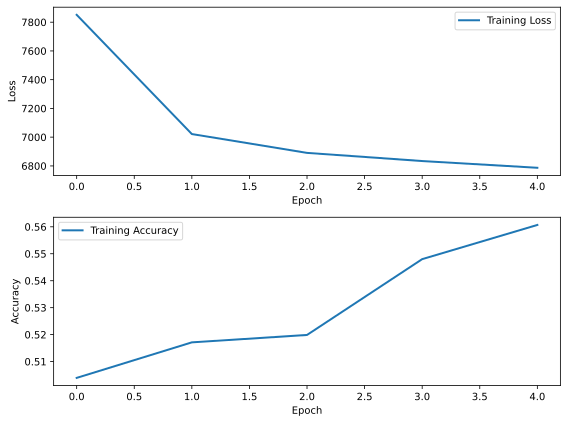

Training:   0%|          | 0/300 [00:00<?, ?it/s]

epoch: 6, avg_loss: 6748.8701171875
epoch: 6, avg_acc: 0.5695013999938965


Training:   0%|          | 0/300 [00:00<?, ?it/s]

epoch: 7, avg_loss: 6721.2900390625
epoch: 7, avg_acc: 0.570965588092804


Training:   0%|          | 0/300 [00:00<?, ?it/s]

epoch: 8, avg_loss: 6701.16845703125
epoch: 8, avg_acc: 0.5647076964378357


Training:   0%|          | 0/300 [00:00<?, ?it/s]

epoch: 9, avg_loss: 6687.392578125
epoch: 9, avg_acc: 0.5603493452072144


Training:   0%|          | 0/300 [00:00<?, ?it/s]

epoch: 10, avg_loss: 6675.64404296875
epoch: 10, avg_acc: 0.5594762563705444


Eval:   0%|          | 0/50 [00:00<?, ?it/s]

eval loss: 1666.753173828125, eval_acc: 0.5623720288276672
eval accuracy: 0.5623720288276672


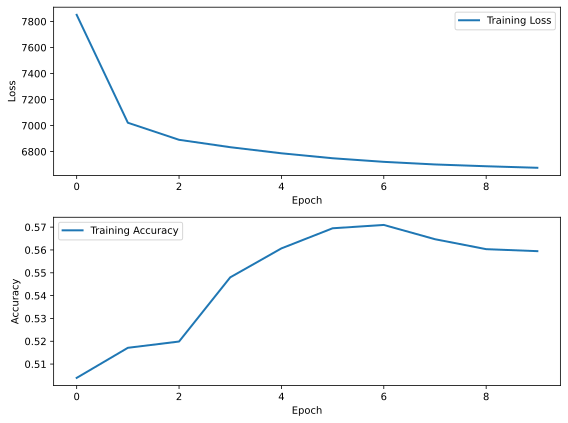

Training:   0%|          | 0/300 [00:00<?, ?it/s]

epoch: 11, avg_loss: 6664.15576171875
epoch: 11, avg_acc: 0.5604536533355713


Training:   0%|          | 0/300 [00:00<?, ?it/s]

epoch: 12, avg_loss: 6653.8173828125
epoch: 12, avg_acc: 0.5629537105560303


Training:   0%|          | 0/300 [00:00<?, ?it/s]

epoch: 13, avg_loss: 6645.36328125
epoch: 13, avg_acc: 0.5651187896728516


Training:   0%|          | 0/300 [00:00<?, ?it/s]

epoch: 14, avg_loss: 6634.94921875
epoch: 14, avg_acc: 0.5681591033935547


Training:   0%|          | 0/300 [00:00<?, ?it/s]

epoch: 15, avg_loss: 6624.40625
epoch: 15, avg_acc: 0.5718303918838501


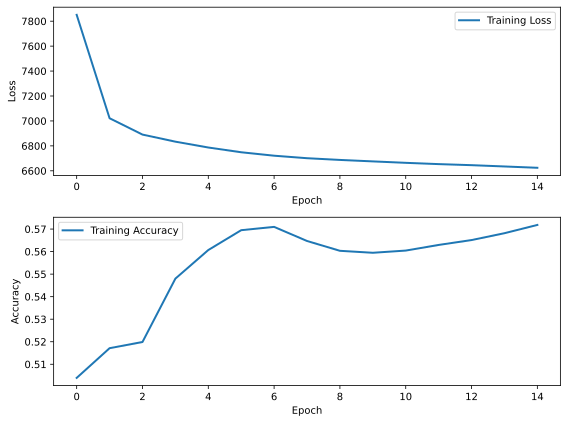

Training:   0%|          | 0/300 [00:00<?, ?it/s]

epoch: 16, avg_loss: 6615.74755859375
epoch: 16, avg_acc: 0.5744621753692627


Training:   0%|          | 0/300 [00:00<?, ?it/s]

epoch: 17, avg_loss: 6606.30908203125
epoch: 17, avg_acc: 0.577728271484375


Training:   0%|          | 0/300 [00:00<?, ?it/s]

epoch: 18, avg_loss: 6596.978515625
epoch: 18, avg_acc: 0.5813810229301453


Training:   0%|          | 0/300 [00:00<?, ?it/s]

epoch: 19, avg_loss: 6588.72509765625
epoch: 19, avg_acc: 0.5846861600875854


Training:   0%|          | 0/300 [00:00<?, ?it/s]

epoch: 20, avg_loss: 6579.9208984375
epoch: 20, avg_acc: 0.5880526900291443


Eval:   0%|          | 0/50 [00:00<?, ?it/s]

eval loss: 1645.5701904296875, eval_acc: 0.5897780060768127
eval accuracy: 0.5897780060768127


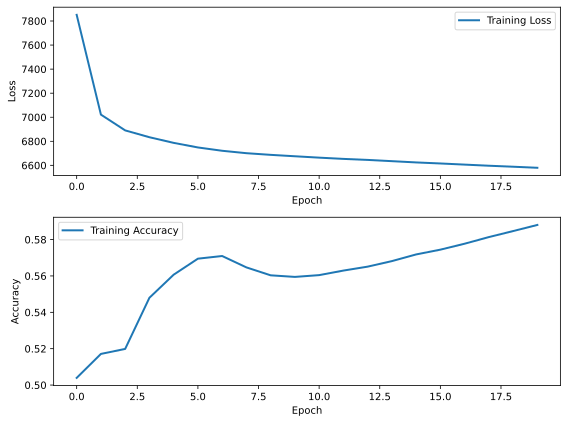

Training:   0%|          | 0/300 [00:00<?, ?it/s]

epoch: 21, avg_loss: 6572.005859375
epoch: 21, avg_acc: 0.590854823589325


Training:   0%|          | 0/300 [00:00<?, ?it/s]

epoch: 22, avg_loss: 6563.40771484375
epoch: 22, avg_acc: 0.5933266282081604


Training:   0%|          | 0/300 [00:00<?, ?it/s]

epoch: 23, avg_loss: 6553.78759765625
epoch: 23, avg_acc: 0.5954906344413757


Training:   0%|          | 0/300 [00:00<?, ?it/s]

epoch: 24, avg_loss: 6544.75439453125
epoch: 24, avg_acc: 0.5974065661430359


Training:   0%|          | 0/300 [00:00<?, ?it/s]

epoch: 25, avg_loss: 6534.9814453125
epoch: 25, avg_acc: 0.5993790030479431


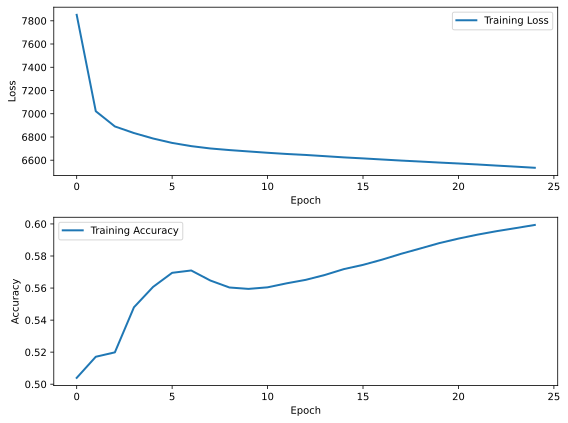

Training:   0%|          | 0/300 [00:00<?, ?it/s]

epoch: 26, avg_loss: 6524.05126953125
epoch: 26, avg_acc: 0.6013267636299133


Training:   0%|          | 0/300 [00:00<?, ?it/s]

epoch: 27, avg_loss: 6513.63330078125
epoch: 27, avg_acc: 0.6030939221382141


Training:   0%|          | 0/300 [00:00<?, ?it/s]

epoch: 28, avg_loss: 6501.1181640625
epoch: 28, avg_acc: 0.6055635809898376


Training:   0%|          | 0/300 [00:00<?, ?it/s]

epoch: 29, avg_loss: 6485.2607421875
epoch: 29, avg_acc: 0.6084948778152466


Training:   0%|          | 0/300 [00:00<?, ?it/s]

epoch: 30, avg_loss: 6471.95068359375
epoch: 30, avg_acc: 0.6115061640739441


Eval:   0%|          | 0/50 [00:00<?, ?it/s]

eval loss: 1614.6534423828125, eval_acc: 0.6138759851455688
eval accuracy: 0.6138759851455688


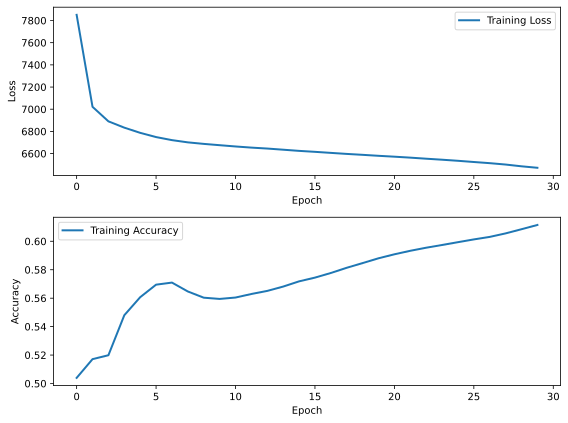

Training:   0%|          | 0/300 [00:00<?, ?it/s]

epoch: 31, avg_loss: 6453.36376953125
epoch: 31, avg_acc: 0.6160078048706055


Training:   0%|          | 0/300 [00:00<?, ?it/s]

epoch: 32, avg_loss: 6437.34521484375
epoch: 32, avg_acc: 0.6198752522468567


Training:   0%|          | 0/300 [00:00<?, ?it/s]

epoch: 33, avg_loss: 6420.78173828125
epoch: 33, avg_acc: 0.62375408411026


Training:   0%|          | 0/300 [00:00<?, ?it/s]

epoch: 34, avg_loss: 6404.107421875
epoch: 34, avg_acc: 0.6265051960945129


Training:   0%|          | 0/300 [00:00<?, ?it/s]

epoch: 35, avg_loss: 6386.37939453125
epoch: 35, avg_acc: 0.628203809261322


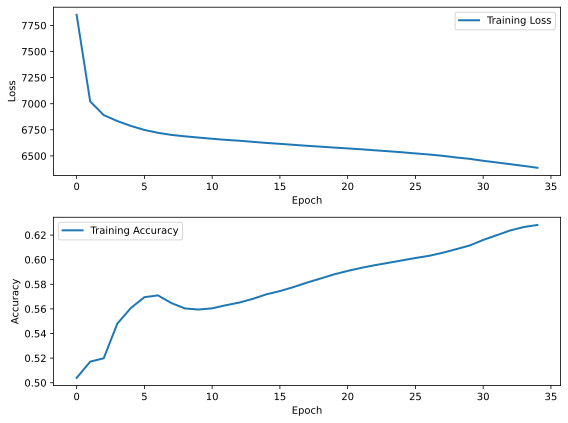

Training:   0%|          | 0/300 [00:00<?, ?it/s]

epoch: 36, avg_loss: 6368.0634765625
epoch: 36, avg_acc: 0.6298708319664001


Training:   0%|          | 0/300 [00:00<?, ?it/s]

epoch: 37, avg_loss: 6351.37939453125
epoch: 37, avg_acc: 0.6310522556304932


Training:   0%|          | 0/300 [00:00<?, ?it/s]

epoch: 38, avg_loss: 6334.8388671875
epoch: 38, avg_acc: 0.6324636936187744


Training:   0%|          | 0/300 [00:00<?, ?it/s]

epoch: 39, avg_loss: 6317.03564453125
epoch: 39, avg_acc: 0.6349330544471741


Training:   0%|          | 0/300 [00:00<?, ?it/s]

epoch: 40, avg_loss: 6300.99267578125
epoch: 40, avg_acc: 0.6392291188240051


Eval:   0%|          | 0/50 [00:00<?, ?it/s]

eval loss: 1573.0875244140625, eval_acc: 0.6399419903755188
eval accuracy: 0.6399419903755188


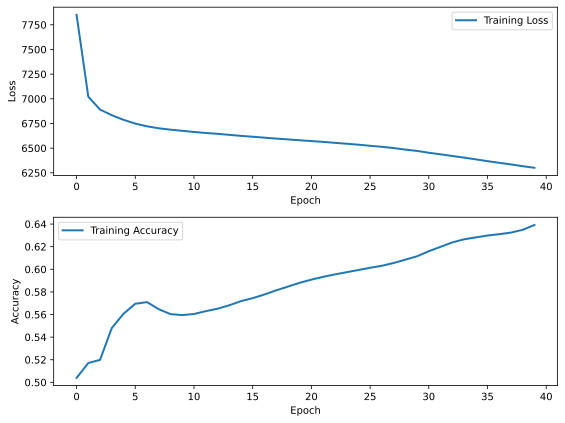

Training:   0%|          | 0/300 [00:00<?, ?it/s]

epoch: 41, avg_loss: 6284.28466796875
epoch: 41, avg_acc: 0.64206463098526


Training:   0%|          | 0/300 [00:00<?, ?it/s]

epoch: 42, avg_loss: 6269.30322265625
epoch: 42, avg_acc: 0.6436259150505066


Training:   0%|          | 0/300 [00:00<?, ?it/s]

epoch: 43, avg_loss: 6256.76904296875
epoch: 43, avg_acc: 0.6448368430137634


Training:   0%|          | 0/300 [00:00<?, ?it/s]

epoch: 44, avg_loss: 6245.25146484375
epoch: 44, avg_acc: 0.6458998918533325


Training:   0%|          | 0/300 [00:00<?, ?it/s]

epoch: 45, avg_loss: 6232.43017578125
epoch: 45, avg_acc: 0.6469672918319702


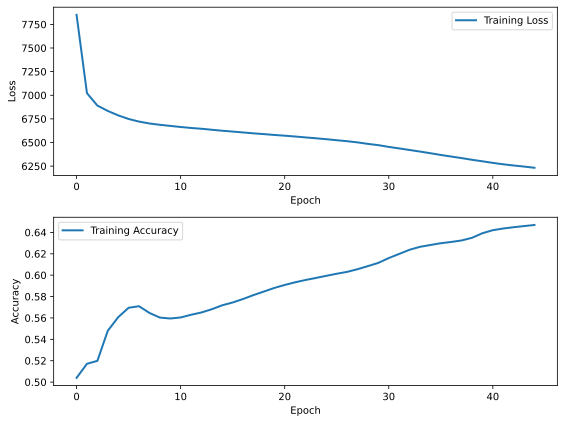

Training:   0%|          | 0/300 [00:00<?, ?it/s]

epoch: 46, avg_loss: 6220.7529296875
epoch: 46, avg_acc: 0.6480182409286499


Training:   0%|          | 0/300 [00:00<?, ?it/s]

epoch: 47, avg_loss: 6212.73486328125
epoch: 47, avg_acc: 0.648900032043457


Training:   0%|          | 0/300 [00:00<?, ?it/s]

epoch: 48, avg_loss: 6204.56396484375
epoch: 48, avg_acc: 0.6495015621185303


Training:   0%|          | 0/300 [00:00<?, ?it/s]

epoch: 49, avg_loss: 6194.34521484375
epoch: 49, avg_acc: 0.6502816677093506


Training:   0%|          | 0/300 [00:00<?, ?it/s]

epoch: 50, avg_loss: 6186.6171875
epoch: 50, avg_acc: 0.6510564684867859


Eval:   0%|          | 0/50 [00:00<?, ?it/s]

eval loss: 1546.7696533203125, eval_acc: 0.6512399911880493
eval accuracy: 0.6512399911880493


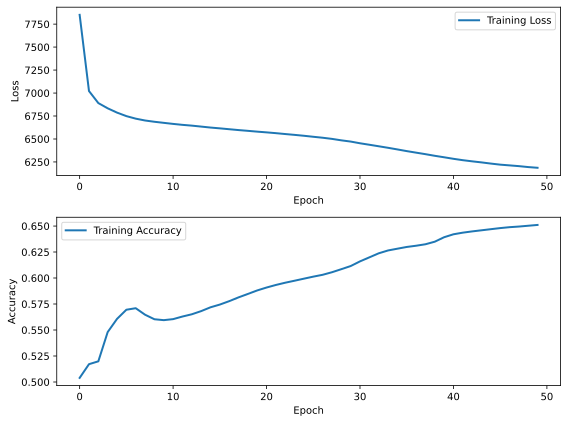

Training:   0%|          | 0/300 [00:00<?, ?it/s]

epoch: 51, avg_loss: 6177.97021484375
epoch: 51, avg_acc: 0.6516386866569519


Training:   0%|          | 0/300 [00:00<?, ?it/s]

epoch: 52, avg_loss: 6170.7265625
epoch: 52, avg_acc: 0.65216463804245


Training:   0%|          | 0/300 [00:00<?, ?it/s]

epoch: 53, avg_loss: 6163.30908203125
epoch: 53, avg_acc: 0.6529565453529358


Training:   0%|          | 0/300 [00:00<?, ?it/s]

epoch: 54, avg_loss: 6156.458984375
epoch: 54, avg_acc: 0.6536593437194824


Training:   0%|          | 0/300 [00:00<?, ?it/s]

epoch: 55, avg_loss: 6148.16015625
epoch: 55, avg_acc: 0.6544587016105652


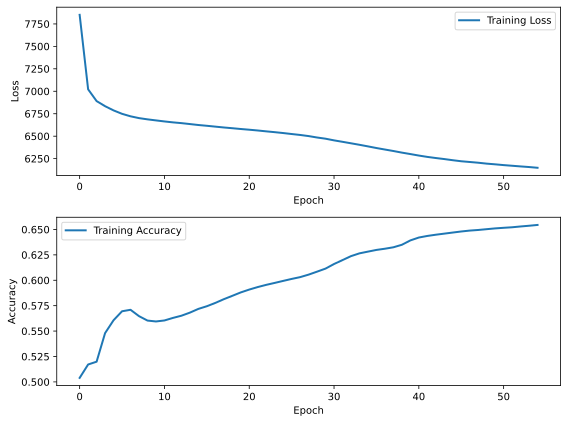

Training:   0%|          | 0/300 [00:00<?, ?it/s]

epoch: 56, avg_loss: 6141.44921875
epoch: 56, avg_acc: 0.6550115942955017


Training:   0%|          | 0/300 [00:00<?, ?it/s]

epoch: 57, avg_loss: 6134.50927734375
epoch: 57, avg_acc: 0.6556679010391235


Training:   0%|          | 0/300 [00:00<?, ?it/s]

epoch: 58, avg_loss: 6128.8369140625
epoch: 58, avg_acc: 0.65645432472229


Training:   0%|          | 0/300 [00:00<?, ?it/s]

epoch: 59, avg_loss: 6122.1005859375
epoch: 59, avg_acc: 0.6570701003074646


Training:   0%|          | 0/300 [00:00<?, ?it/s]

epoch: 60, avg_loss: 6115.31201171875
epoch: 60, avg_acc: 0.6576675176620483


Eval:   0%|          | 0/50 [00:00<?, ?it/s]

eval loss: 1529.0721435546875, eval_acc: 0.6582919955253601
eval accuracy: 0.6582919955253601


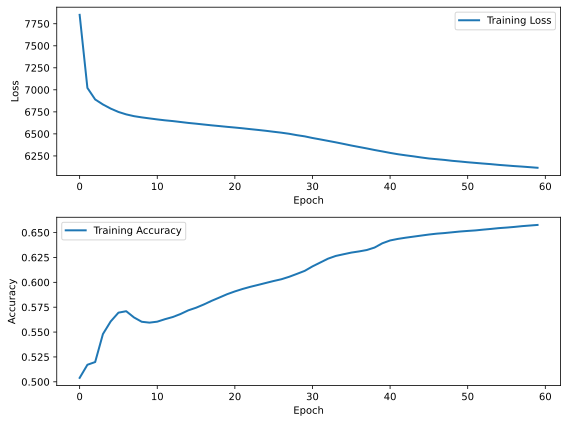

Training:   0%|          | 0/300 [00:00<?, ?it/s]

epoch: 61, avg_loss: 6107.716796875
epoch: 61, avg_acc: 0.6582489013671875


Training:   0%|          | 0/300 [00:00<?, ?it/s]

epoch: 62, avg_loss: 6100.6220703125
epoch: 62, avg_acc: 0.6587880253791809


Training:   0%|          | 0/300 [00:00<?, ?it/s]

epoch: 63, avg_loss: 6095.9462890625
epoch: 63, avg_acc: 0.6587213277816772


Training:   0%|          | 0/300 [00:00<?, ?it/s]

epoch: 64, avg_loss: 6087.7978515625
epoch: 64, avg_acc: 0.6592301726341248


Training:   0%|          | 0/300 [00:00<?, ?it/s]

epoch: 65, avg_loss: 6080.5166015625
epoch: 65, avg_acc: 0.659785270690918


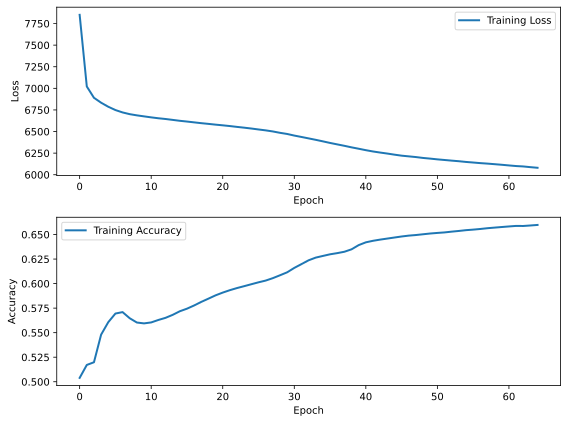

Training:   0%|          | 0/300 [00:00<?, ?it/s]

epoch: 66, avg_loss: 6070.4404296875
epoch: 66, avg_acc: 0.6607645750045776


Training:   0%|          | 0/300 [00:00<?, ?it/s]

epoch: 67, avg_loss: 6062.046875
epoch: 67, avg_acc: 0.6621353030204773


Training:   0%|          | 0/300 [00:00<?, ?it/s]

epoch: 68, avg_loss: 6052.89453125
epoch: 68, avg_acc: 0.6636557579040527


Training:   0%|          | 0/300 [00:00<?, ?it/s]

epoch: 69, avg_loss: 6042.52001953125
epoch: 69, avg_acc: 0.6656361222267151


Training:   0%|          | 0/300 [00:00<?, ?it/s]

epoch: 70, avg_loss: 6034.09716796875
epoch: 70, avg_acc: 0.6675416827201843


Eval:   0%|          | 0/50 [00:00<?, ?it/s]

eval loss: 1506.5589599609375, eval_acc: 0.6697940230369568
eval accuracy: 0.6697940230369568


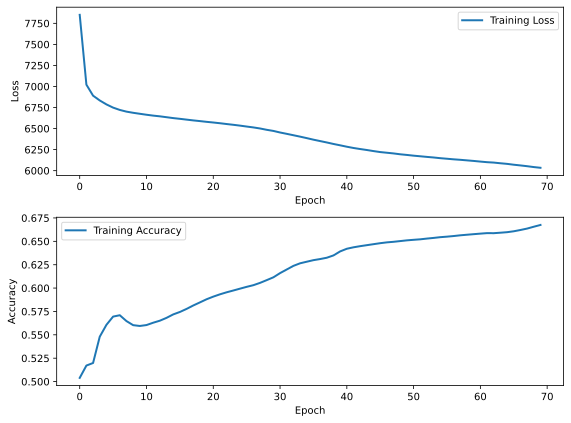

Training:   0%|          | 0/300 [00:00<?, ?it/s]

epoch: 71, avg_loss: 6022.95263671875
epoch: 71, avg_acc: 0.6695680022239685


Training:   0%|          | 0/300 [00:00<?, ?it/s]

epoch: 72, avg_loss: 6013.072265625
epoch: 72, avg_acc: 0.6716063618659973


Training:   0%|          | 0/300 [00:00<?, ?it/s]

epoch: 73, avg_loss: 6000.77392578125
epoch: 73, avg_acc: 0.6736518144607544


Training:   0%|          | 0/300 [00:00<?, ?it/s]

epoch: 74, avg_loss: 5990.802734375
epoch: 74, avg_acc: 0.6754505634307861


Training:   0%|          | 0/300 [00:00<?, ?it/s]

epoch: 75, avg_loss: 5980.408203125
epoch: 75, avg_acc: 0.6773897409439087


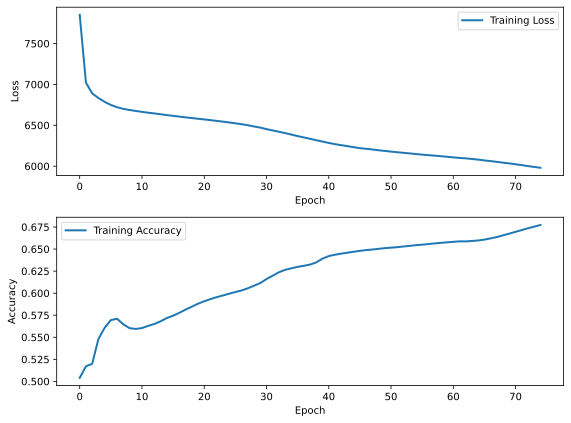

Training:   0%|          | 0/300 [00:00<?, ?it/s]

epoch: 76, avg_loss: 5967.49169921875
epoch: 76, avg_acc: 0.679513156414032


Training:   0%|          | 0/300 [00:00<?, ?it/s]

epoch: 77, avg_loss: 5956.72021484375
epoch: 77, avg_acc: 0.6813259124755859


Training:   0%|          | 0/300 [00:00<?, ?it/s]

epoch: 78, avg_loss: 5945.3056640625
epoch: 78, avg_acc: 0.6831889748573303


Training:   0%|          | 0/300 [00:00<?, ?it/s]

epoch: 79, avg_loss: 5934.359375
epoch: 79, avg_acc: 0.6846310496330261


Training:   0%|          | 0/300 [00:00<?, ?it/s]

epoch: 80, avg_loss: 5922.38720703125
epoch: 80, avg_acc: 0.6862345933914185


Eval:   0%|          | 0/50 [00:00<?, ?it/s]

eval loss: 1480.1025390625, eval_acc: 0.6862980127334595
eval accuracy: 0.6862980127334595


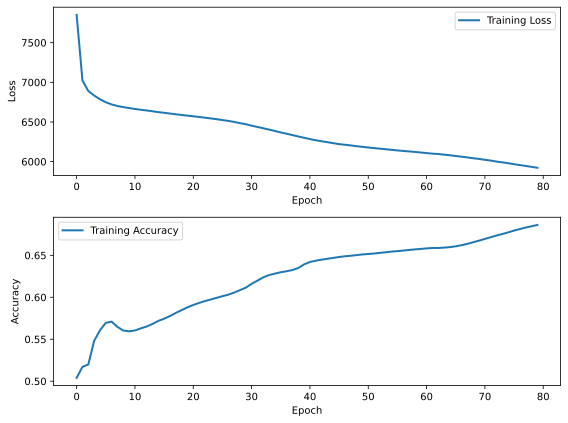

Training:   0%|          | 0/300 [00:00<?, ?it/s]

epoch: 81, avg_loss: 5912.5126953125
epoch: 81, avg_acc: 0.6877927780151367


Training:   0%|          | 0/300 [00:00<?, ?it/s]

epoch: 82, avg_loss: 5902.56494140625
epoch: 82, avg_acc: 0.6887702345848083


Training:   0%|          | 0/300 [00:00<?, ?it/s]

epoch: 83, avg_loss: 5894.19580078125
epoch: 83, avg_acc: 0.6898430585861206


Training:   0%|          | 0/300 [00:00<?, ?it/s]

epoch: 84, avg_loss: 5884.6474609375
epoch: 84, avg_acc: 0.6908057928085327


Training:   0%|          | 0/300 [00:00<?, ?it/s]

epoch: 85, avg_loss: 5874.19921875
epoch: 85, avg_acc: 0.6917420625686646


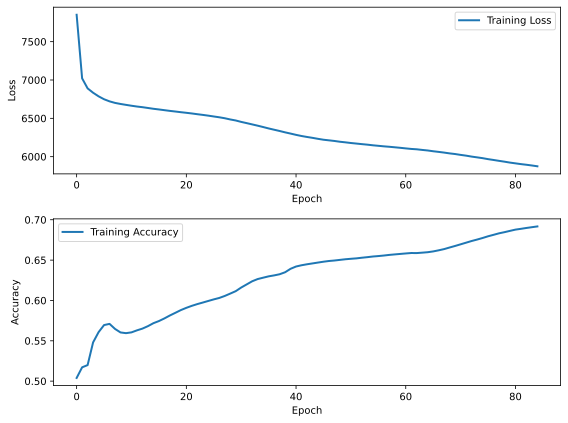

Training:   0%|          | 0/300 [00:00<?, ?it/s]

epoch: 86, avg_loss: 5866.62939453125
epoch: 86, avg_acc: 0.6923957467079163


Training:   0%|          | 0/300 [00:00<?, ?it/s]

epoch: 87, avg_loss: 5860.302734375
epoch: 87, avg_acc: 0.6928279399871826


Training:   0%|          | 0/300 [00:00<?, ?it/s]

epoch: 88, avg_loss: 5850.74365234375
epoch: 88, avg_acc: 0.6936856508255005


Training:   0%|          | 0/300 [00:00<?, ?it/s]

epoch: 89, avg_loss: 5845.203125
epoch: 89, avg_acc: 0.694098174571991


Training:   0%|          | 0/300 [00:00<?, ?it/s]

epoch: 90, avg_loss: 5838.283203125
epoch: 90, avg_acc: 0.6945576071739197


Eval:   0%|          | 0/50 [00:00<?, ?it/s]

eval loss: 1456.8570556640625, eval_acc: 0.6951200366020203
eval accuracy: 0.6951200366020203


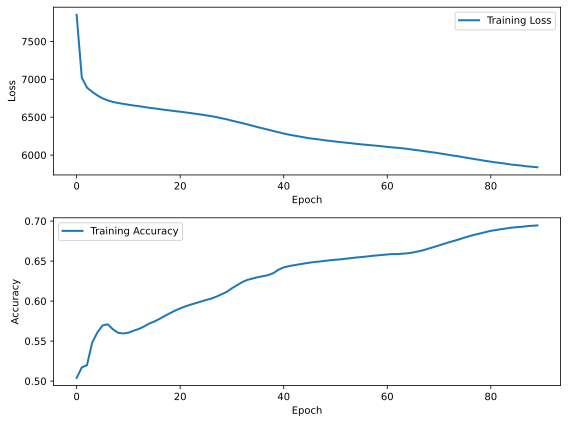

Training:   0%|          | 0/300 [00:00<?, ?it/s]

epoch: 91, avg_loss: 5831.14794921875
epoch: 91, avg_acc: 0.6950238347053528


Training:   0%|          | 0/300 [00:00<?, ?it/s]

epoch: 92, avg_loss: 5824.50927734375
epoch: 92, avg_acc: 0.6955147385597229


Training:   0%|          | 0/300 [00:00<?, ?it/s]

epoch: 93, avg_loss: 5818.07421875
epoch: 93, avg_acc: 0.6959917545318604


Training:   0%|          | 0/300 [00:00<?, ?it/s]

epoch: 94, avg_loss: 5811.533203125
epoch: 94, avg_acc: 0.6965522170066833


Training:   0%|          | 0/300 [00:00<?, ?it/s]

epoch: 95, avg_loss: 5804.43994140625
epoch: 95, avg_acc: 0.6971420049667358


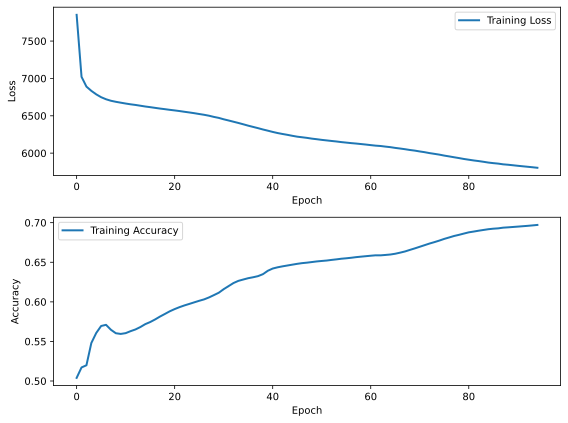

Training:   0%|          | 0/300 [00:00<?, ?it/s]

epoch: 96, avg_loss: 5797.080078125
epoch: 96, avg_acc: 0.6977049112319946


Training:   0%|          | 0/300 [00:00<?, ?it/s]

epoch: 97, avg_loss: 5789.67822265625
epoch: 97, avg_acc: 0.6982712745666504


Training:   0%|          | 0/300 [00:00<?, ?it/s]

epoch: 98, avg_loss: 5785.02001953125
epoch: 98, avg_acc: 0.6986006498336792


Training:   0%|          | 0/300 [00:00<?, ?it/s]

epoch: 99, avg_loss: 5778.5791015625
epoch: 99, avg_acc: 0.699058473110199


Training:   0%|          | 0/300 [00:00<?, ?it/s]

epoch: 100, avg_loss: 5770.71728515625
epoch: 100, avg_acc: 0.6996797919273376


Eval:   0%|          | 0/50 [00:00<?, ?it/s]

eval loss: 1441.8768310546875, eval_acc: 0.699116051197052
eval accuracy: 0.699116051197052


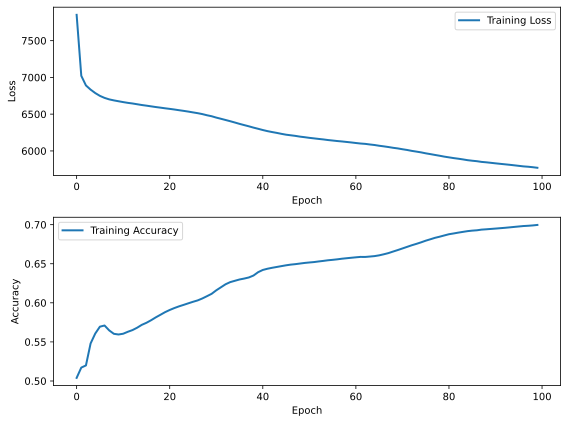

Eval:   0%|          | 0/50 [00:00<?, ?it/s]

eval loss: 1441.860595703125, eval_acc: 0.6996279954910278


Eval:   0%|          | 0/10 [00:00<?, ?it/s]

eval loss: 1440.29296875, eval_acc: 0.6991199851036072


In [718]:
ca_trainer, ca_result = train_1step_rule30(model_dim=8,
                                                num_heads=8,
                                                num_layers=2,
                                                dropout_prob=0.0,
                                                lr=1e-5,
                                                warmup=50)

In [719]:
print(f"Val accuracy:  {(100.0 * ca_result['val_acc']):4.2f}%")
print(f"Test accuracy: {(100.0 * ca_result['test_acc']):4.2f}%")

Val accuracy:  69.96%
Test accuracy: 69.91%


In [720]:
def predict(trainer, inp_data):
    """Makes predictions using the trained model."""
    return trainer.model_bd(inp_data, train=False)

In [723]:
def evolve_neural(trainer, initial_state, steps):
    state = initial_state.copy()
    history = [state.copy()]

    for _ in range(steps):
        state = np.expand_dims(state, axis=-1)
        state = predict(trainer, state)
        state = nn.sigmoid(state)
        min_val = np.min(state)  # Find the minimum value
        max_val = np.max(state)  # Find the maximum value

        normalized_arr = (state - min_val) / (max_val - min_val)  # Min-max scaling
        state = normalized_arr
        state = (jnp.array(state) >= 0.5).astype(int)
        state = np.squeeze(state)
        history.append(state.copy())
    return history

def evolve(rule, initial_state, steps):
    state = initial_state.copy()
    history = [state.copy()]

    for _ in range(steps):
        state = apply_rule(state, rule)
        history.append(state.copy())

    return history

    return history
def plot_evolution(history):
    plt.figure(figsize=(10, 10))
    plt.imshow(history, cmap="binary", interpolation="nearest", origin="lower")
    plt.show()

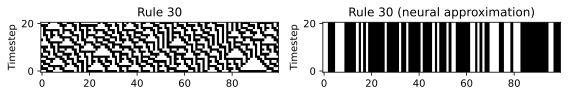

In [725]:
initial_state = np.random.randint(0, 2, size=100)
steps = 20
evolution_history_rule30 = evolve(rule30, initial_state, steps)
neural_history_rule30 = evolve_neural(ca_trainer, initial_state, steps)
fig_combined, axes = plt.subplots(1, 2, figsize=(8, 4))

axes[0].imshow(evolution_history_rule30, cmap="binary", interpolation="nearest", origin="lower") # Get the image data
axes[0].set_title("Rule 30")
axes[0].set_ylabel("Timestep")

axes[1].imshow(neural_history_rule30, cmap="binary", interpolation="nearest", origin="lower") # Get the image data
axes[1].set_title("Rule 30 (neural approximation)")
axes[1].set_ylabel("Timestep")

plt.tight_layout()
plt.show()

#Conclusions
Strangely, I was not able to get the transformers to learn even basic ECA rules. I tried a variety of architecture configurations ranging from 12 layers to 1, and with embedding dimensions from 512 to 1. None of them were able to learn the appropriate rules. They all learned one of two rules: either cells that were active at timestep $t-1$ would remain active, or cells would all switch state between time steps (as shown above). Possible reasons for this are that CA data is typically relatively unbalanced, with more "alive" or "dead" cells at any point. I thought using focal loss might alleviate this, but it didn't. Nor did trying different optimizers, or using a learning rate warmup schedule. Modelling this as a masked language modelling task is probably a better approach, with each state (rather than each cell within a state) being a token.